In [1]:
# Built-in modules
import os
from enum import Enum

# Machine learning 
import lightgbm as lgb
import joblib

# Basics of Python data handling and visualization
import numpy as np
import matplotlib.pyplot as plt

#from sklearn.externals import joblib
from sklearn import metrics
#from sklearn import preprocessing

# Imports from eo-learn and sentinelhub-py
from eolearn.core import EOTask, EOPatch, LinearWorkflow, FeatureType, OverwritePermission, \
    LoadFromDisk, SaveToDisk, EOExecutor
#from eolearn.io import S2L1CWCSInput, ExportToTiff
#from eolearn.mask import AddCloudMaskTask, get_s2_pixel_cloud_detector, AddValidDataMaskTask
#from eolearn.geometry import VectorToRaster, PointSamplingTask, ErosionTask
from eolearn.features import LinearInterpolation, SimpleFilterTask, ValueFilloutTask
#from sentinelhub import BBoxSplitter, BBox, CRS, CustomUrlParam

In [8]:
# load sampled eopatches
DATA_FOLDER = 'N:\CropInventoryAutomation\crop_large'
eopatches = []
path_out_sampled = os.path.join(DATA_FOLDER, 'eopatches_sampled')

for i in range(3):
    eopatches.append(EOPatch.load('{}/eopatch_{}'.format(path_out_sampled, i+15), lazy_loading=True))    

eopatches = np.array(eopatches)

In [9]:
# Definition of the train and test patch IDs
train_ID = [0]
test_ID = [1,2] 

# Set the features and the labels for train and test sets
features_train = np.array([eopatch.data['FEATURES_SAMPLED'] for eopatch in eopatches[train_ID]])
labels_train = np.array([eopatch.mask_timeless['LULC_ERODED_SAMPLED'] for eopatch in eopatches[train_ID]])
features_test = np.array([eopatch.data['FEATURES_SAMPLED'] for eopatch in eopatches[test_ID]])
labels_test = np.array([eopatch.mask_timeless['LULC_ERODED_SAMPLED'] for eopatch in eopatches[test_ID]])

# get shape
p1, t, w, h, f = features_train.shape
p2, t, w, h, f = features_test.shape
p = p1 + p2

# reshape to n x m
features_train = np.moveaxis(features_train, 1, 3).reshape(p1 * w * h, t * f)
labels_train = np.moveaxis(labels_train, 1, 2).reshape(p1 * w * h, 1).squeeze()
features_test = np.moveaxis(features_test, 1, 3).reshape(p2 * w * h, t * f)
labels_test = np.moveaxis(labels_test, 1, 2).reshape(p2 * w * h, 1).squeeze()

# remove points with no reference from training (so we dont train to recognize "no data")
mask_train = labels_train == 0
features_train = features_train[~mask_train]
labels_train = labels_train[~mask_train]

# remove points with no reference from test (so we dont validate on "no data", which doesn't make sense)
mask_test = labels_test == 0
features_test = features_test[~mask_test]
labels_test = labels_test[~mask_test]

In [10]:
%%time

# Set up training classes
labels_unique = np.unique(labels_train)

# Set up the model
model = lgb.LGBMClassifier(
    objective='multiclass', 
    num_class=len(labels_unique),
    # Metric parameters
    metric='multi_logloss',  # loss for multi classification
    # Core parameters
    #boosting='rf',
    num_iterations=100,  # Int (default=100); Note: internally, LightGBM constructs num_class * num_iterations trees for multi-class classification problems
    #learning_rate=0.01,  # Double (default=0.1); Determines the impact of each tree on the final outcome; Typical values: 0.1, 0.001, 0.003...
    #num_leaves=31,  # Int (default=31); Max number of leaves in one tree
    # Control parameters
    #feature_fraction=0.8,  # Double (default=1) 0.0 < feature_fraction <= 1.0; used when boosting_type='rf'
    #bagging_fraction=1,  # Double (default=1) 0.0 < bagging_fraction <= 1.0; can be used to speed up training and deal with over-fitting; need bagging_freq>=1
    #bagging_freq=0,  # Int (default=0); 0 means disable bagging; k means perform bagging at every k iteration; need bagging_fraction<1 aswell
    #max_depth=-1,  # Int (default=-1); <= 0 means no limit; limit the max depth for tree model. This is used to deal with over-fitting when data is small
    #min_data_in_leaf=20,  # Int (default=20); minimal number of data in one leaf. Can be used to deal with over-fitting
    # IO parameters
    #max_bin=255,  # Default 255, use larger number for more accuracy; smaller number to deal with over-fitting
    #save_binary=True  # For dealing with the memory size of your data file then specify this parameter as ‘True’
)

# train the model
model.fit(features_train, labels_train)
# uncomment to save the model
model_base_name = 'model_LULC_crops_large'
joblib.dump(model, os.path.join(DATA_FOLDER, '{}.pkl'.format(model_base_name)))

C:\Users\bruneautousignantc\AppData\Local\Continuum\anaconda3\envs\arcgispro\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Wall time: 2min 16s


['N:\\CropInventoryAutomation\\crop_large\\model_LULC_crops_large.pkl']

### Validation

In [10]:
class LULC(Enum):
    NO_DATA            = (0,  'No Data',                    'white')
    HAY                = (1,  'Hay',                        '#0cff0c')  # xkcd:neon green
    CORN               = (2,  'Corn',                       '#fe019a')  # xkcd:neon pink
    SOY                = (3,  'Soy',                        '#cfff04')  # xkcd:neon yellow
    VARIOUS_CROPS      = (4,  'Various crops',              '#fa5ff7')  # xkcd:light magenta
    ARTIFICIAL_SURFACE = (5,  'Human-modified environment', 'crimson')
    SHRUBLAND          = (6,  'Old field / Shrubland',      'xkcd:tan')
    FOREST             = (7,  'Forest environment',         'xkcd:darkgreen')
    WETLAND            = (8,  'Wetland',                    'xkcd:lightblue')
    WATER              = (9,  'Open water',                 'xkcd:azure')
    BARELAND           = (10, 'Bare ground',                'xkcd:beige')
    
    def __init__(self, val1, val2, val3):
        self.id = val1
        self.class_name = val2
        self.color = val3

In [11]:
%%time

model_base_name = 'model_900it_large_full'

model_path = os.path.join(DATA_FOLDER, '{}.pkl'.format(model_base_name))
model = joblib.load(model_path)

# predict the test labels
plabels_test = model.predict(features_test)

print('Classification accuracy {:.1f}%'.format(100 * metrics.accuracy_score(labels_test, plabels_test)))
print('Classification F1-score {:.1f}%'.format(100 * metrics.f1_score(labels_test, plabels_test, average='weighted')))

class_labels = np.unique(labels_test)
class_names = [entry.class_name for entry in LULC]

f1_scores = metrics.f1_score(labels_test, plabels_test, labels=class_labels, average=None)
recall = metrics.recall_score(labels_test, plabels_test, labels=class_labels, average=None)
precision = metrics.precision_score(labels_test, plabels_test, labels=class_labels, average=None) 
print('             Class                        =  F1  | Recall | Precision')
print('         --------------------------------------------------')
for idx, lulctype in enumerate([class_names[idx] for idx in class_labels]):
    print('         * {0:30s} = {1:2.1f} |  {2:2.1f}  | {3:2.1f}'.format(lulctype, 
                                                                         f1_scores[idx] * 100, 
                                                                         recall[idx] * 100, 
                                                                         precision[idx] * 100))

Classification accuracy 87.9%
Classification F1-score 87.2%
             Class                        =  F1  | Recall | Precision
         --------------------------------------------------
         * Hay                            = 74.9 |  78.4  | 71.8
         * Corn                           = 93.6 |  96.9  | 90.4
         * Soy                            = 90.8 |  94.6  | 87.4
         * Various crops                  = 71.3 |  60.9  | 85.9
         * Human-modified environment     = 81.9 |  82.9  | 80.9
         * Old field / Shrubland          = 51.1 |  44.0  | 60.9
         * Forest environment             = 92.4 |  94.1  | 90.7
         * Wetland                        = 9.4 |  7.0  | 14.6
         * Open water                     = 86.5 |  92.6  | 81.1
         * Bare ground                    = 0.0 |  0.0  | 0.0
Wall time: 15min 35s


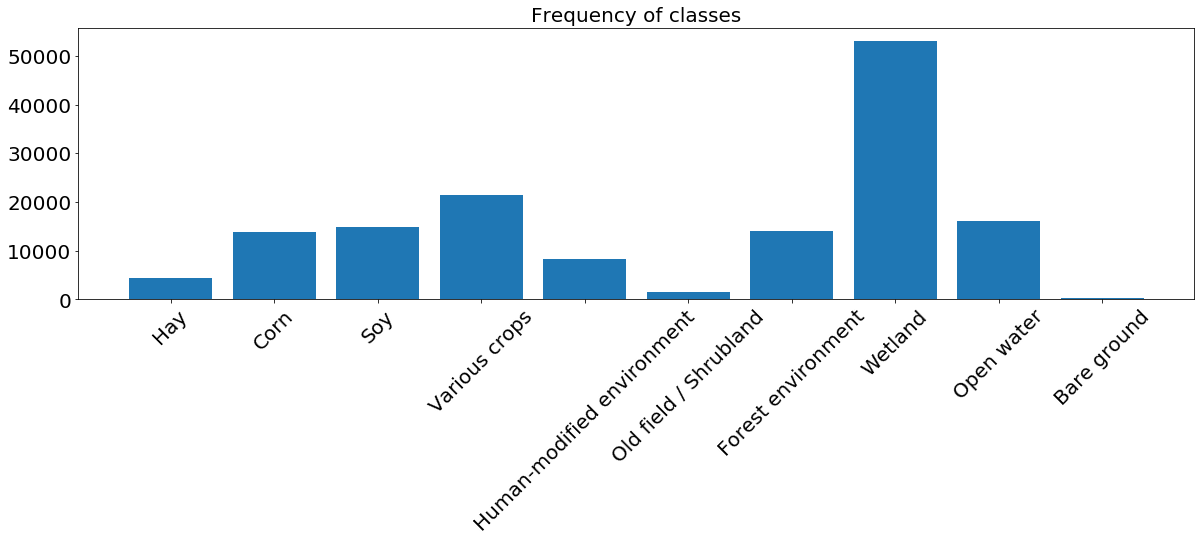

In [21]:
fig = plt.figure(figsize=(20, 5))

label_ids, label_counts = np.unique(labels_train, return_counts=True)
plt.title('Frequency of classes', fontsize=20)
plt.bar(range(len(label_ids)), label_counts)
plt.xticks(range(len(label_ids)), [class_names[i] for i in label_ids], rotation=45, fontsize=20);
plt.yticks(fontsize=20);

[[  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [ 46  29  33  25  21  30   0  31 185 125  13  14   0]
 [ 38  22  18  16  13  15   0  21  79  83  18  20   0]
 [ 40  44  32  41  23  25   0  19 117  90  18  33   0]
 [105  53  46 151 113  98   0  93 220 214  46  51   0]
 [ 41  18  18  49  54  57   0  68 134 118  33  41   0]
 [ 61  22  95  98  79  72   0  74 126  96  81  63   0]
 [215  94 179  97 119 118   0 151 260 168 136 211   0]
 [147  86 150 115  99 159   0 148 194 153 155 121   0]
 [ 95  62  70  48  45  61   0 115  92  87 129  67   0]
 [ 84  65  57  60  90  88   0  75 119 128  74  69   0]
 [ 98 117 113  97 119  92   0  67 148 209 148  67   0]
 [ 82 176 133 134 242 155   0 112 205 398 200  80   0]
 [111  89 105  80 164 121   0  71 184 169 112  99   0]
 [193 196 126 139 151 140   0 123 217 129  99 191   0]
 [271 207 283 210 218 208   0 244 331 195 191 276   0]
 [193 172 252 229 181 193   0 157 237 268 167 193   0]
 [202 179 

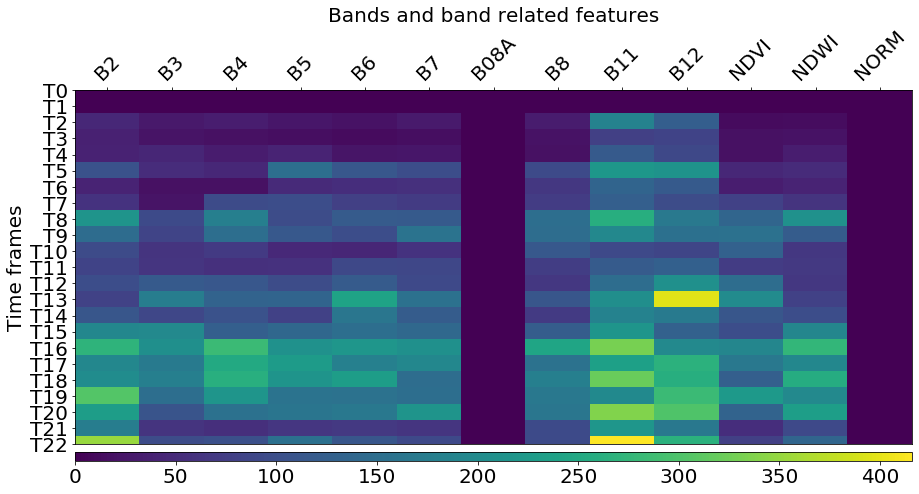

In [23]:
# names of features
fnames = ['B2','B3','B4', 'B5', 'B6', 'B7', 'B8A', 'B8','B11','B12','NDVI','NDWI','NORM']

# get feature importances and reshape them to dates and features
z = model.feature_importances_.reshape((t, f))
print(z)
fig = plt.figure(figsize=(15, 15))
ax = plt.gca()

# plot the importances
im = ax.imshow(z, aspect=0.25)
plt.xticks(range(len(fnames)), fnames, rotation=45, fontsize=20)
plt.yticks(range(t), ['T{}'.format(i) for i in range(t)], fontsize=20)
plt.xlabel('Bands and band related features', fontsize=20)
plt.ylabel('Time frames', fontsize=20)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 

# cax = fig.add_axes([0.82, 0.125, 0.04, 0.755]) 
# plt.colorbar(im, cax=cax)

fig.subplots_adjust(wspace=0, hspace=0)

cb = fig.colorbar(im, ax=[ax], orientation='horizontal', pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=20) 